In [1]:
import os
import urllib
import rasterio as rio
import rasterio.plot
import requests
import matplotlib.pyplot as plt
from dateutil import parser

## Download Collection 2 (L2) products for Surface Reflectance and Surface Temperature

In [2]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is A056-A881

 Directory of c:\Users\alan\Dropbox\PC (2)\Documents\github\nz-landslides\notebooks

03/07/2024  06:40 PM    <DIR>          .
03/07/2024  06:40 PM    <DIR>          ..
03/07/2024  06:39 PM           248,654 0-reading-brute-raw-data.ipynb
03/07/2024  06:39 PM             5,281 1-tile-dems.ipynb
03/07/2024  06:39 PM           128,293 2-create-vrt.ipynb
03/07/2024  06:39 PM           980,842 3-interacting-vrt-polygon.ipynb
03/07/2024  06:39 PM           866,122 4-calculating-differences&correlations.ipynb
03/08/2024  01:27 AM           367,746 download_ndvi.ipynb
03/08/2024  01:27 AM         2,853,741 landsat-c2-example(1).ipynb
03/08/2024  01:08 AM           347,035 match_nvdi_to_polygons.ipynb
               8 File(s)      5,797,714 bytes
               2 Dir(s)  691,776,368,640 bytes free


In [3]:
#Create local directory to store images

imgdir="../1-raw-data/ndvi"
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

### Download assets for specific images
* Dynamimcally construct url using known information
* Using Microsoft Planetary Computer archive of Collection 2 Level 2 images
    * https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
* Need to obtain token to authenticate ("sign") urls

In [4]:
#Collection name
collection = 'landsat-c2-l2'

In [5]:
#Base url for this collection
base_url = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs'

In [14]:
#List of predetermined images (e.g., from STAC, or interactive EarthExplorer or EarthData search)
img_list = ['LC08_L2SP_073089_20161215_20200905_02_T1']
img_list = ['LC08_L2SP_073089_20161215_20200905_02_T1',
            'LC08_L2SP_073089_20160419_20200907_02_T1',
            'LC08_L2SP_073089_20161012_20200905_02_T1',
            'LC08_L2SP_073089_20161215_20200905_02_T1',
            'LC08_L2SP_073089_20171202_20200902_02_T1',
            'LC08_L2SP_073089_20181018_20200830_02_T1',
            'LC08_L2SP_073089_20201210_20210313_02_T1',
            'LC09_L2SP_073089_20221106_20230323_02_T1',
            'LC09_L2SP_073089_20221122_20230321_02_T1',  ]

# img_list = ['LC08_L2SP_073089_20221114_20221122_02_T']

In [19]:
img_fn = os.path.join('../1-raw-data/ndvi/autoselected_images.txt')

img_list = []

with open(img_fn, 'r') as f:
    for l in f:
        line = l.split(',')
        date = parser.parse(line[0])

        if date.month > 9:

            img_list.append(line[1][:-1])


In [7]:
# Get a token for signed url preparation
resp = requests.get(f'https://planetarycomputer.microsoft.com/api/sas/v1/token/{collection}')
token = resp.json()['token']
token

'st=2024-03-07T16%3A44%3A05Z&se=2024-03-08T17%3A29%3A05Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-03-08T13%3A21%3A50Z&ske=2024-03-15T13%3A21%3A50Z&sks=b&skv=2021-06-08&sig=YloOJGrvMOzYS9VTryZ1XKIy/2Vz4/AeH4zcnt00eTY%3D'

## Download images, compute NDVI, and save product

In [8]:
def download_ndvi(img, plot=False, overwrite = False):
    b4 = 'SR_B4'
    b5 = 'SR_B5'
    
    #Generate the appropriate URL for the image IDs
    year = img.split('_')[3][0:4]
    path = img.split('_')[2][0:3]
    row = img.split('_')[2][3:]
    image_url_b4 =  f'{base_url}/{year}/{path}/{row}/{img}/{img}_{b4}.TIF'
    image_url_b5 =  f'{base_url}/{year}/{path}/{row}/{img}/{img}_{b5}.TIF'

    #Local filename
    out_fn = os.path.join(imgdir, img + '_ndvi.TIF')
    print(out_fn)

    if not os.path.exists(out_fn) or overwrite:
        with rio.open(f'{image_url_b4}?{token}') as r_src:
            with rio.open(f'{image_url_b5}?{token}') as nir_src: 
    
                r = r_src.read(1, masked = True).astype('float')
                nir = nir_src.read(1, masked=True).astype('float')
                ndvi = (nir-r)/(r+nir)
                ndvi_masked = ndvi[ndvi < 5]
                ndvi_masked = ndvi_masked[ndvi_masked > 0.1]
                print(ndvi_masked.shape)
    
                
                if plot:
                    plt.imshow(ndvi, cmap = "viridis", vmin = 0.1, vmax = 5)
    
                
                # Write to TIFF
                kwargs = r_src.meta
                kwargs.update(
                    dtype=rasterio.float32,
                    count=1,
                    nodata=999.9)

                print("Saving:", out_fn)
                #Download the file

                with rasterio.open(out_fn, 'w', **kwargs) as dst:
                    dst.write(ndvi.astype(rasterio.float32),1)
                print("done")

    else:
        print("File already exists")

    return ndvi

In [18]:
images_with_errors = []
for img in img_list:
    try:
        download_ndvi(img, False, False)
    except Exception as e:
        images_with_errors.append(img)
        print(e)

../1-raw-data/ndvi\LC08_L2SP_073089_20231219_20240103_02_T1_ndvi.TIF
File already exists
local variable 'ndvi' referenced before assignment
../1-raw-data/ndvi\LC07_L2SP_074089_20231210_20240105_02_T1_ndvi.TIF
'/vsicurl/https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2023/074/089/LC07_L2SP_074089_20231210_20240105_02_T1/LC07_L2SP_074089_20231210_20240105_02_T1_SR_B4.TIF?st=2024-03-07T16%3A44%3A05Z&se=2024-03-08T17%3A29%3A05Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-03-08T13%3A21%3A50Z&ske=2024-03-15T13%3A21%3A50Z&sks=b&skv=2021-06-08&sig=YloOJGrvMOzYS9VTryZ1XKIy/2Vz4/AeH4zcnt00eTY%3D' not recognized as a supported file format.
../1-raw-data/ndvi\LC09_L2SP_073089_20231125_20231128_02_T1_ndvi.TIF
File already exists
local variable 'ndvi' referenced before assignment
../1-raw-data/ndvi\LC08_L2SP_073089_20221114_20221122_02_T1_ndvi.TIF
File already exists
local variable 'ndvi' ref

In [10]:
images_with_errors

['LC08_L2SP_073089_20231219_20240103_02_T1',
 'LE07_L2SP_074089_20231210_20240105_02_T1',
 'LC09_L2SP_073089_20231125_20231128_02_T1',
 'LC08_L2SP_073089_20221114_20221122_02_T1',
 'LC09_L2SP_073089_20221106_20221110_02_T1',
 'LE07_L2SP_073089_20221104_20221130_02_T1',
 'LE07_L2SP_073089_20201202_20201229_02_T1',
 'LE07_L2SP_073089_20201031_20201127_02_T1',
 'LC08_L2SP_073089_20201023_20201105_02_T1',
 'LE07_L2SP_073089_20201015_20201111_02_T1',
 'LC08_L2SP_073089_20191208_20200824_02_T1',
 'LC08_L2SP_073089_20191005_20200825_02_T1',
 'LE07_L2SP_073089_20181111_20200827_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LE07_L2SP_073089_20171210_20200830_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LE07_L2SP_073089_20171108_20200830_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LE07_L2SP_073089_20161121_20200901_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LE07_L2SP_074089_20151228_20200903_02_T1',
 'LE07_L2SP_073089_20151002_20200903_02_T1']

In [21]:
test_src = download_ndvi(img_list[0],False, True)

../1-raw-data/ndvi\LC08_L2SP_073089_20231219_20240103_02_T1_ndvi.TIF
(18326662,)
Saving: ../1-raw-data/ndvi\LC08_L2SP_073089_20231219_20240103_02_T1_ndvi.TIF


CPLE_AppDefinedError: Deleting ../1-raw-data/ndvi\LC08_L2SP_073089_20231219_20240103_02_T1_ndvi.TIF failed: Permission denied

In [19]:
test_src = download_ndvi(img_list[0],False, True)

../1-raw-data/ndvi\LC08_L2SP_073089_20161215_20200905_02_T1_ndvi.TIF
(18087643,)
Saving: ../1-raw-data/ndvi\LC08_L2SP_073089_20161215_20200905_02_T1_ndvi.TIF
done


In [20]:
test_src.meta

NameError: name 'test_src' is not defined

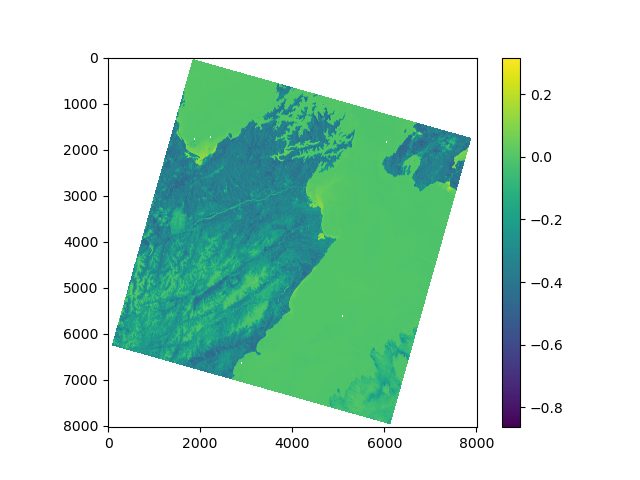

In [ ]:
plt.imshow(test_src, cmap = "viridis")
plt.colorbar()

In [ ]:
%matplotlib widget